In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


## 1. Load and Prepare Data

Load your h5ad file and configure the dataset parameters.

In [2]:
DATA_PATH = "/home/b5cc/sanjukta.b5cc/aracneseq/datasets/k562_5k.h5ad" 
PERT_COL = "gene"  
CONTROL_NAME = "non-targeting"  

#NUM_BINS = 
USE_LOG_TRANSFORM = False  # Apply log1p transform before discretization

# Training parameters
BATCH_SIZE = 64
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4
MASK_RATIO = 0.15  # Fraction of genes to mask during training

# Model size ("small", "medium", or "large")
MODEL_SIZE = "small"

# =================================================

print("Configuration:")
print(f"  Data path: {DATA_PATH}")
print(f"  Perturbation column: {PERT_COL}")
print(f"  Control name: {CONTROL_NAME}")
print(f"  Log transform: {USE_LOG_TRANSFORM}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Model size: {MODEL_SIZE}")

Configuration:
  Data path: /home/b5cc/sanjukta.b5cc/aracneseq/datasets/k562_5k.h5ad
  Perturbation column: gene
  Control name: non-targeting
  Log transform: False
  Batch size: 64
  Epochs: 5
  Learning rate: 0.0001
  Model size: small


In [3]:
# Load the h5ad file
print(f"Loading data from {DATA_PATH}...")
adata = sc.read_h5ad(DATA_PATH)

print(f"\nDataset info:")
print(f"  Shape: {adata.shape} (cells × genes)")
print(f"  Number of cells: {adata.n_obs:,}")
print(f"  Number of genes: {adata.n_vars:,}")

# Check perturbation column
if PERT_COL not in adata.obs.columns:
    raise ValueError(f"Perturbation column '{PERT_COL}' not found in data. Available columns: {list(adata.obs.columns)}")

# Count perturbations
pert_counts = adata.obs[PERT_COL].value_counts()
print(f"\nPerturbation info:")
print(f"  Total unique perturbations: {len(pert_counts)}")
print(f"  Control cells ({CONTROL_NAME}): {pert_counts.get(CONTROL_NAME, 0):,}")
print(f"  Perturbed cells: {adata.n_obs - pert_counts.get(CONTROL_NAME, 0):,}")

print(f"\nTop 10 perturbations:")
for pert, count in pert_counts.head(10).items():
    print(f"  {pert}: {count:,} cells")

Loading data from /home/b5cc/sanjukta.b5cc/aracneseq/datasets/k562_5k.h5ad...

Dataset info:
  Shape: (5000, 8563) (cells × genes)
  Number of cells: 5,000
  Number of genes: 8,563

Perturbation info:
  Total unique perturbations: 1651
  Control cells (non-targeting): 152
  Perturbed cells: 4,848

Top 10 perturbations:
  non-targeting: 152 cells
  RPL3: 31 cells
  NCBP2: 23 cells
  KIF11: 17 cells
  ARGLU1: 14 cells
  PMPCB: 14 cells
  SLC39A9: 13 cells
  RPL34: 12 cells
  NUP205: 12 cells
  FBXO5: 12 cells


Expression matrix shape: (5000, 8563)
Expression range: 0.00 to 1723.00
Sparsity (zeros): 57.7%


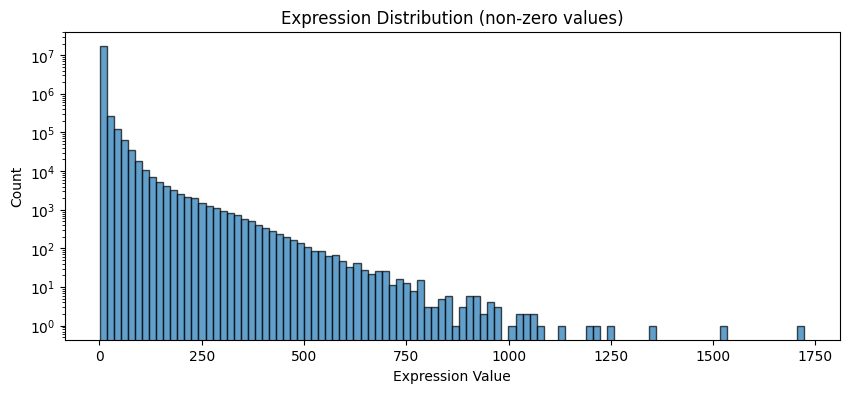


Expression statistics (non-zero values):
  Mean: 3.84
  Median: 1.00
  Std: 13.13


In [4]:
# Extract expression matrix
# Handle sparse matrices
if hasattr(adata.X, 'toarray'):
    expression = adata.X.toarray()
else:
    expression = adata.X

print(f"Expression matrix shape: {expression.shape}")
print(f"Expression range: {expression.min():.2f} to {expression.max():.2f}")
print(f"Sparsity (zeros): {(expression == 0).sum() / expression.size:.1%}")

# Visualize expression distribution
non_zero_expr = expression[expression > 0]
plt.figure(figsize=(10, 4))
plt.hist(non_zero_expr.flatten(), bins=100, alpha=0.7, edgecolor='black')
plt.xlabel('Expression Value')
plt.ylabel('Count')
plt.title('Expression Distribution (non-zero values)')
plt.yscale('log')
plt.show()

print(f"\nExpression statistics (non-zero values):")
print(f"  Mean: {non_zero_expr.mean():.2f}")
print(f"  Median: {np.median(non_zero_expr):.2f}")
print(f"  Std: {non_zero_expr.std():.2f}")

In [5]:
NUM_BINS = int(adata.X.max())  
print(NUM_BINS)

1723


## 3. Create Dataset and DataLoaders

In [6]:
from sedd.data import PerturbSeqDataset, train_val_split
import numpy as np
import torch

CONTROL_NAME = "non-targeting"
# Extract perturbation labels
#pert_labels = adata.obs[PERT_COL].values
pert_labels = adata.obs["gene"].astype(str).to_numpy()
gene_names = adata.var_names.tolist()

expression = adata.X.toarray() if hasattr(adata.X, "toarray") else np.asarray(adata.X)
NUM_BINS = int(expression.max())
# Create dataset
print("Creating PerturbSeqDataset...")
dataset = PerturbSeqDataset(
    expression=expression,
    pert_labels=pert_labels,
    gene_names=gene_names,
    num_bins=NUM_BINS,
    control_pert_name=CONTROL_NAME,
)

# Split into train/val
train_dataset, val_dataset = train_val_split(dataset, val_fraction=0.1, seed=42)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset):,} samples")
print(f"  Val: {len(val_dataset):,} samples")



Creating PerturbSeqDataset...
PerturbSeqDataset: 4848 perturbed cells, 152 control cells, 1651 perturbations

Dataset sizes:
  Train: 4,364 samples
  Val: 484 samples


In [7]:
#Create dataloaders
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False,
)

print(f"\nDataLoader info:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

# Test the dataloader
control, pert_label, perturbed = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Control shape: {control.shape}")
print(f"  Pert label shape: {pert_label.shape}")
print(f"  Perturbed shape: {perturbed.shape}")

# Store dataset parameters
NUM_GENES = dataset.num_genes
NUM_PERTURBATIONS = dataset.num_perturbations
VOCAB_SIZE = NUM_BINS + 1  # +1 for mask token

print(f"\nModel parameters:")
print(f"  NUM_GENES: {NUM_GENES}")
print(f"  NUM_BINS: {NUM_BINS}")
print(f"  NUM_PERTURBATIONS: {NUM_PERTURBATIONS}")
print(f"  VOCAB_SIZE: {VOCAB_SIZE}")


DataLoader info:
  Train batches: 69
  Val batches: 8

Sample batch:
  Control shape: torch.Size([64, 8563])
  Pert label shape: torch.Size([64])
  Perturbed shape: torch.Size([64, 8563])

Model parameters:
  NUM_GENES: 8563
  NUM_BINS: 1723
  NUM_PERTURBATIONS: 1651
  VOCAB_SIZE: 1724


## 4. Create SEDD Model

In [8]:
from sedd.model import (
    SEDDPerturbationTransformerSmall,
    SEDDPerturbationTransformerMedium,
    SEDDPerturbationTransformerLarge,
)
from sedd.graph import AbsorbingGraph
from sedd.noise import LogLinearNoise

# Select model size
if MODEL_SIZE == "small":
    ModelClass = SEDDPerturbationTransformerSmall
    model_config = {"hidden_dim": 8, "num_layers": 2, "num_heads": 2, "max_seq_len":8565}
elif MODEL_SIZE == "medium":
    ModelClass = SEDDPerturbationTransformerMedium
    model_config = {"hidden_dim": 256, "num_layers": 6, "num_heads": 8}
elif MODEL_SIZE == "large":
    ModelClass = SEDDPerturbationTransformerLarge
    model_config = {"hidden_dim": 512, "num_layers": 8, "num_heads": 8}
else:
    raise ValueError(f"Invalid model size: {MODEL_SIZE}. Choose 'small', 'medium', or 'large'.")

print(f"Creating {MODEL_SIZE} SEDD model...")
print(f"  Config: {model_config}")

# Create model
model = ModelClass(
    num_genes=NUM_GENES,
    num_bins=NUM_BINS,
    num_perturbations=NUM_PERTURBATIONS,
    dropout=0.1,
).to(device)

# Create diffusion graph (absorbing state = mask token)
graph = AbsorbingGraph(num_states=VOCAB_SIZE)

# Create noise schedule
noise = LogLinearNoise(eps=1e-3)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel info:")
print(f"  Total parameters: {num_params:,}")
print(f"  Trainable parameters: {num_trainable:,}")
print(f"  Device: {next(model.parameters()).device}")

Creating small SEDD model...
  Config: {'hidden_dim': 8, 'num_layers': 2, 'num_heads': 2, 'max_seq_len': 8565}

Model info:
  Total parameters: 3,098,624
  Trainable parameters: 3,098,624
  Device: cpu


## 5. Train the Model

In [9]:
from sedd.trainer import PerturbationTrainer

# Create trainer
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
trainer = PerturbationTrainer(
    model=model,
    graph=graph,
    noise=noise,
    optimizer=optimizer,
    device=device,
    gradient_clip=1.0,
)
#trainer = PerturbationTrainer(
#
#     model=model,
#    graph=graph,
#    noise=noise,
#    device=device,
#    learning_rate=LEARNING_RATE,

#    gradient_clip=1.0,
#)

print(f"Trainer created. Starting training for {NUM_EPOCHS} epochs...\n")

Trainer created. Starting training for 5 epochs...



In [10]:
# Add this before trainer.train()
batch = next(iter(train_loader))

# If batch is a list or tuple, try to get the first tensor
if isinstance(batch, (list, tuple)):
    first_tensor = batch[0]
else:
    first_tensor = batch

# Print sequence length if possible
if hasattr(first_tensor, "shape") and len(first_tensor.shape) > 1:
    print(f"Sequence length: {first_tensor.shape[1]}")
else:
    print("Cannot determine sequence length: batch does not have expected shape.")

Sequence length: 8563


In [ ]:
# Get one batch
batch = next(iter(train_loader))
x = batch['x'] if isinstance(batch, dict) else batch[0]

print(f"--- Debugging Embedding Dimensions ---")
print(f"Input shape (batch_size, seq_len): {x.shape}")
print(f"Max value in data (tokens): {x.max().item()}")
print(f"Min value in data (tokens): {x.min().item()}")

# Check model capacities
print(f"\nModel Token Embedding Capacity: {model.token_embed.num_embeddings}")
print(f"Model Gene/Pos Embedding Capacity: {model.gene_embed.num_embeddings}")

# Logic Check
if x.max() >= model.token_embed.num_embeddings:
    print("❌ ERROR: Your data contains token values larger than token_embed can handle!")
    
if x.shape[1] > model.gene_embed.num_embeddings:
    print("❌ ERROR: Your sequence length is larger than gene_embed can handle!")

--- Debugging Embedding Dimensions ---
Input shape (batch_size, seq_len): torch.Size([64, 8563])
Max value in data (tokens): 895
Min value in data (tokens): 0

Model Token Embedding Capacity: 1724
Model Gene/Pos Embedding Capacity: 8565


: 

In [ ]:
# Train the model
history = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    mask_ratio=MASK_RATIO,
    log_interval=1,
    val_interval=1,
)

print("\nTraining complete!")
print(f"Final train loss: {history['train_loss'][-1]:.4f}")
print(f"Final val loss: {history['val_loss'][-1]:.4f}")
print(f"Best val loss: {trainer.best_loss:.4f}")

Epoch 1/5:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
# Plot training curves
fig, ax = plt.subplots(figsize=(10, 5))

epochs = range(1, len(history['train_loss']) + 1)
ax.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Progress', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Inference and Evaluation

In [ ]:
# Set model to eval mode
model.eval()

# Get a test batch from validation set
test_control, test_pert_labels, test_perturbed = next(iter(val_loader))
test_control = test_control.to(device)
test_pert_labels = test_pert_labels.to(device)
test_perturbed = test_perturbed.to(device)

print(f"Test batch:")
print(f"  Controls: {test_control.shape}")
print(f"  Pert labels: {test_pert_labels.shape}")
print(f"  True perturbed: {test_perturbed.shape}")

# Simple inference: forward pass with low noise
# For production, you'd use the full sampling procedure
with torch.no_grad():
    batch_size = test_control.shape[0]
    
    # Start from all masked
    x_init = torch.full((batch_size, NUM_GENES), NUM_BINS, device=device, dtype=torch.long)
    
    # Forward pass with low noise
    sigma = torch.ones(batch_size, device=device) * 0.01
    logits = model(x_init, sigma, test_pert_labels)
    predicted = logits.argmax(dim=-1)

print(f"\nPredicted perturbed cells: {predicted.shape}")

In [ ]:
# Evaluate predictions
with torch.no_grad():
    # Exact match accuracy
    accuracy = (predicted == test_perturbed).float().mean().item()
    print(f"Evaluation metrics:")
    print(f"  Exact match accuracy: {accuracy:.2%}")
    
    # Mean absolute error
    mae = (predicted - test_perturbed).abs().float().mean().item()
    print(f"  Mean Absolute Error: {mae:.2f} bins")
    
    # Within-k accuracy
    for k in [1, 3, 5, 10]:
        within_k = ((predicted - test_perturbed).abs() <= k).float().mean().item()
        print(f"  Within {k} bins: {within_k:.2%}")
    
    # Per-gene correlation
    correlations = []
    for gene_idx in range(NUM_GENES):
        true_gene = test_perturbed[:, gene_idx].float().cpu().numpy()
        pred_gene = predicted[:, gene_idx].float().cpu().numpy()
        if true_gene.std() > 0 and pred_gene.std() > 0:
            corr = np.corrcoef(true_gene, pred_gene)[0, 1]
            if not np.isnan(corr):
                correlations.append(corr)
    
    if correlations:
        print(f"  Average per-gene correlation: {np.mean(correlations):.3f}")

In [ ]:
# Visualize predictions vs ground truth
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
true_flat = test_perturbed.cpu().numpy().flatten()
pred_flat = predicted.cpu().numpy().flatten()
max_val = NUM_BINS

# Sample points for visualization (to avoid overcrowding)
sample_size = min(10000, len(true_flat))
sample_idx = np.random.choice(len(true_flat), sample_size, replace=False)
true_sample = true_flat[sample_idx]
pred_sample = pred_flat[sample_idx]

axes[0].scatter(true_sample, pred_sample, alpha=0.2, s=5)
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('True Expression (bin)', fontsize=12)
axes[0].set_ylabel('Predicted Expression (bin)', fontsize=12)
axes[0].set_title('Predicted vs True Expression', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Error distribution
errors = pred_flat - true_flat
axes[1].hist(errors, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='r', linestyle='--', linewidth=2, label='Zero error')
axes[1].set_xlabel('Prediction Error (bins)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Prediction Error Distribution', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Visualize Example Predictions

In [ ]:
# Visualize a single cell prediction
cell_idx = 0

control_cell = test_control[cell_idx].cpu().numpy()
true_perturbed = test_perturbed[cell_idx].cpu().numpy()
pred_perturbed = predicted[cell_idx].cpu().numpy()
pert_label = test_pert_labels[cell_idx].item()

# Get perturbation name if available
if dataset.idx_to_pert is not None:
    pert_name = dataset.idx_to_pert[pert_label]
else:
    pert_name = f"Perturbation {pert_label}"

# Visualize subset of genes
n_genes_viz = min(200, NUM_GENES)
gene_indices = np.arange(n_genes_viz)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Control
axes[0].bar(gene_indices, control_cell[:n_genes_viz], alpha=0.7, width=1.0, color='blue')
axes[0].set_ylabel('Expression (bin)', fontsize=11)
axes[0].set_title(f'Control Cell Expression (first {n_genes_viz} genes)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# True perturbed
axes[1].bar(gene_indices, true_perturbed[:n_genes_viz], alpha=0.7, width=1.0, color='red')
axes[1].set_ylabel('Expression (bin)', fontsize=11)
axes[1].set_title(f'True Perturbed Cell - {pert_name}', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Predicted
axes[2].bar(gene_indices, pred_perturbed[:n_genes_viz], alpha=0.7, width=1.0, color='green')
axes[2].set_ylabel('Expression (bin)', fontsize=11)
axes[2].set_title(f'Predicted Perturbed Cell', fontsize=12)
axes[2].grid(True, alpha=0.3, axis='y')

# Error
error = (pred_perturbed - true_perturbed)[:n_genes_viz]
colors = ['green' if abs(e) <= 5 else 'orange' if abs(e) <= 10 else 'red' for e in error]
axes[3].bar(gene_indices, error, alpha=0.7, width=1.0, color=colors)
axes[3].axhline(0, color='black', linestyle='--', linewidth=1)
axes[3].set_xlabel('Gene Index', fontsize=11)
axes[3].set_ylabel('Prediction Error', fontsize=11)
axes[3].set_title('Prediction Error (Green: ≤5, Orange: ≤10, Red: >10 bins)', fontsize=12)
axes[3].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Cell metrics
cell_acc = (true_perturbed == pred_perturbed).mean()
cell_mae = np.abs(pred_perturbed - true_perturbed).mean()
print(f'\nCell {cell_idx} ({pert_name}) metrics:')
print(f'  Accuracy: {cell_acc:.2%}')
print(f'  MAE: {cell_mae:.2f} bins')

## 8. Save Model

In [ ]:
import os

# Create checkpoints directory
os.makedirs('../checkpoints', exist_ok=True)

# Save model
checkpoint_path = f'../checkpoints/sedd_perturbation_{MODEL_SIZE}.pt'
trainer.save_checkpoint(checkpoint_path)
print(f'Model saved to {checkpoint_path}')

# Save training history
import pickle
history_path = f'../checkpoints/sedd_perturbation_{MODEL_SIZE}_history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(history, f)
print(f'Training history saved to {history_path}')

## 9. Load Model (Optional)

To load a saved model for inference or continued training:

In [ ]:
# Example: Load a saved model
# Uncomment to use

# new_model = ModelClass(
#     num_genes=NUM_GENES,
#     num_bins=NUM_BINS,
#     num_perturbations=NUM_PERTURBATIONS,
#     dropout=0.1,
# ).to(device)

# new_trainer = PerturbationTrainer(
#     model=new_model,
#     graph=graph,
#     noise=noise,
#     device=device,
# )

# new_trainer.load_checkpoint(checkpoint_path)
# print(f'Model loaded from {checkpoint_path}')
# print(f'Trained for {new_trainer.epoch + 1} epochs')
# print(f'Best validation loss: {new_trainer.best_loss:.4f}')